In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from utilities.imports import *

In [3]:
#typical example setup
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
x_train, y_train, x_valid, y_valid = get_data(MNIST_URL)
x_train, x_valid = normalize_to(x_train, x_valid)

number_hidden = 50
batch_size = 512
num_categories = y_train.max().item()+1

loss_function = F.cross_entropy

training_ds = Dataset(x_train, y_train)
validation_ds = Dataset(x_valid, y_valid)
train_dl = DataLoader(training_ds, batch_size, shuffle = True) #random sampler
valid_dl = DataLoader(validation_ds, batch_size*2, shuffle = False) #sequential sampler
number_features = [8,16,32,32]

In [4]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder, partial(AvgStatsCallback, accuracy), CudaCallback, partial(IndependentVarBatchTransformCallback, mnist_view)]
model = SequentialModel(*get_cnn_layers(num_categories, number_features))
opt = optim.SGD(model.parameters(), lr=0.4)
runner = Runner(cb_funcs=cbfs)
model

SequentialModel(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Lambda()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [6]:
runner.fit(2, model, opt, loss_function, train_dl, valid_dl)

train: [1.9033734375, tensor(0.3485, device='cuda:0')]
valid: [0.76902890625, tensor(0.7544, device='cuda:0')]
train: [0.394975703125, tensor(0.8793, device='cuda:0')]
valid: [0.3587166748046875, tensor(0.8865, device='cuda:0')]


### Examining Mean and STD through training

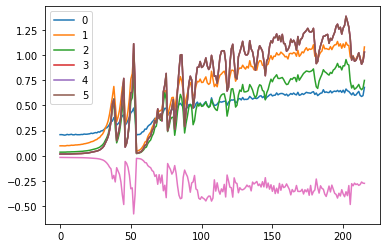

In [7]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

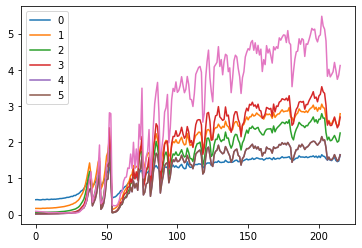

In [8]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

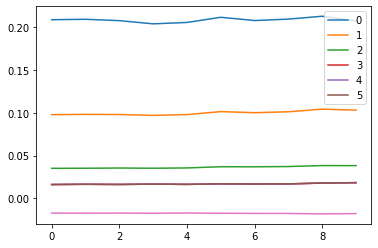

In [9]:
#plotting first 10 batches
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

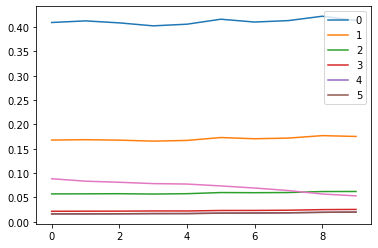

In [10]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

## Getting finer details and telemetry through Pytorch Hooks
##### Downside of Callbacks Class (and subclasses): cannot execute an action at the layer calculation level


In [11]:
model = get_cnn_model(num_categories, number_features)
opt = optim.SGD(model.parameters(), lr=0.5)
runner = Runner(cb_funcs=cbfs)
#global way to implement hooks
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

#hooking function
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())
#attaching the hooking function to each layer
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [12]:
runner.fit(1, model, opt, loss_function, train_dl, valid_dl)

train: [1.6939696875, tensor(0.4172, device='cuda:0')]
valid: [0.66756650390625, tensor(0.7771, device='cuda:0')]


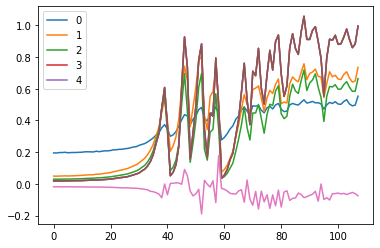

In [13]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

In [14]:
def children(m): return list(m.children())

#used to register a forward hook 
class ForwardHook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'):
        hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [15]:
model = get_cnn_model(num_categories, number_features)
opt = optim.SGD(model.parameters(), lr=0.5)
runner = Runner(cb_funcs=cbfs)
hooks = [ForwardHook(l, append_stats) for l in children(model)]

In [16]:
runner.fit(1, model, opt, loss_function, train_dl, valid_dl)

train: [2.295419375, tensor(0.1769, device='cuda:0')]
valid: [2.2823537109375, tensor(0.1782, device='cuda:0')]


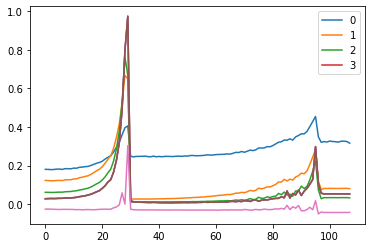

In [17]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### Container Class for Hooks

In [18]:
#numpy style object container
class ListContainer():
    def __init__(self, items): self.items = convert_to_list(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res
    
    
#hooks container
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([ForwardHook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self): #removes all registered hooks
        for h in self: h.remove()

In [19]:
model = get_cnn_model(num_categories, number_features).cuda()
opt = optim.SGD(model.parameters(), lr=0.5)
runner = Runner(cb_funcs=cbfs)
hooks = Hooks(model, append_stats)

In [20]:
print(hooks)
hooks.remove() #
print(hooks)

Hooks (7 items)
[<__main__.ForwardHook object at 0x000001CD1728F6C8>, <__main__.ForwardHook object at 0x000001CD1728FEC8>, <__main__.ForwardHook object at 0x000001CD1A4F3608>, <__main__.ForwardHook object at 0x000001CD1A4F30C8>, <__main__.ForwardHook object at 0x000001CD1A4F3BC8>, <__main__.ForwardHook object at 0x000001CD1A4F3748>, <__main__.ForwardHook object at 0x000001CD1A4F3CC8>]
Hooks (7 items)
[<__main__.ForwardHook object at 0x000001CD1728F6C8>, <__main__.ForwardHook object at 0x000001CD1728FEC8>, <__main__.ForwardHook object at 0x000001CD1A4F3608>, <__main__.ForwardHook object at 0x000001CD1A4F30C8>, <__main__.ForwardHook object at 0x000001CD1A4F3BC8>, <__main__.ForwardHook object at 0x000001CD1A4F3748>, <__main__.ForwardHook object at 0x000001CD1A4F3CC8>]


In [21]:
x,y = next(iter(train_dl))
x = mnist_resize(x).cuda()
print(x.mean(),x.std())

tensor(-0.0008, device='cuda:0') tensor(0.9988, device='cuda:0')


In [22]:
for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

p = model[0](x)
p.mean(),p.std()

(tensor(0.3876, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.6980, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.078818046875, tensor(0.6554, device='cuda:0')]
valid: [0.2406681396484375, tensor(0.9291, device='cuda:0')]
train: [0.1898246484375, tensor(0.9418, device='cuda:0')]
valid: [0.19390096435546875, tensor(0.9409, device='cuda:0')]


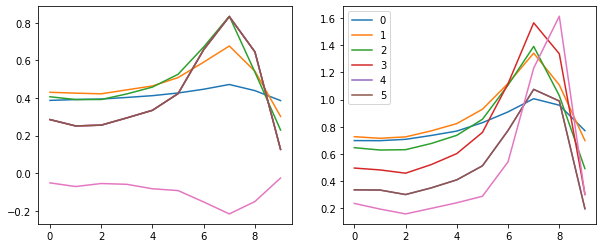

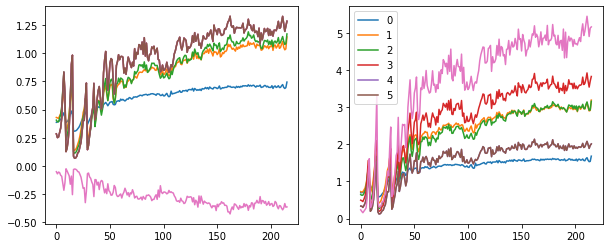

In [23]:
with Hooks(model, append_stats) as hooks:
    runner.fit(2, model, opt, loss_function, train_dl, valid_dl)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [24]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [25]:
model = get_cnn_model(num_categories, number_features).cuda()
opt = optim.SGD(model.parameters(), lr=0.9) #high lr for demonstration purposes, examine histograms
runner = Runner(cb_funcs=cbfs)
hooks = Hooks(model, append_stats)
for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [26]:
with Hooks(model, append_stats) as hooks: 
    runner.fit(1, model, opt, loss_function, train_dl, valid_dl)

train: [1.57494546875, tensor(0.4686, device='cuda:0')]
valid: [0.2946428955078125, tensor(0.9138, device='cuda:0')]


In [27]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

### High Learning Rate Histograms, first 4 layers

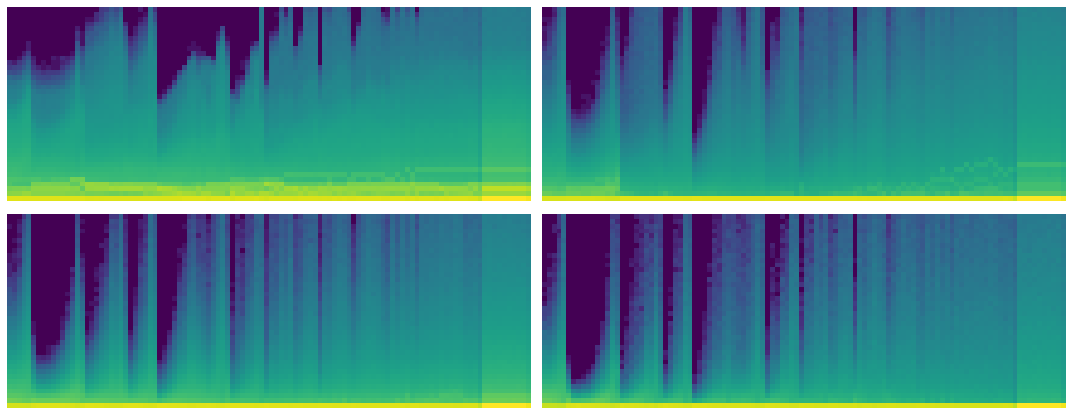

In [28]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

### Normal Learning Rate Histograms

train: [1.198519921875, tensor(0.6189, device='cuda:0')]
valid: [0.534948486328125, tensor(0.8390, device='cuda:0')]


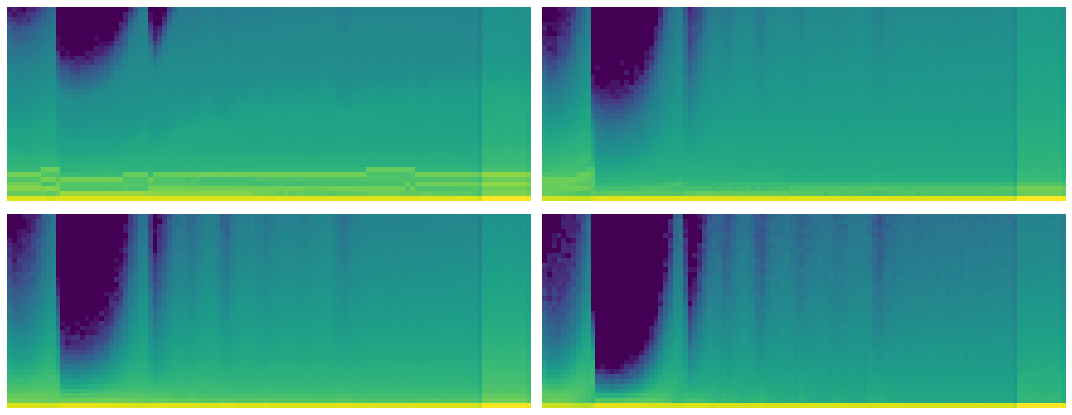

In [29]:
model = get_cnn_model(num_categories, number_features).cuda()
opt = optim.SGD(model.parameters(), lr=0.4) #high lr for demonstration purposes, examine histograms
runner = Runner(cb_funcs=cbfs)
hooks = Hooks(model, append_stats)
for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()
with Hooks(model, append_stats) as hooks: 
    runner.fit(1, model, opt, loss_function, train_dl, valid_dl)
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

#### What our Histograms Represent:
- graph -> convolutional layer
- Yellow Line -> the "most energy"
    1. alot of the activations are at 0
- x-axis -> iteration #
- y-axis -> # of activations that are at their min or max values
    1. dark blue - activations that are 0
    2. light blue - activations that are (near) their max

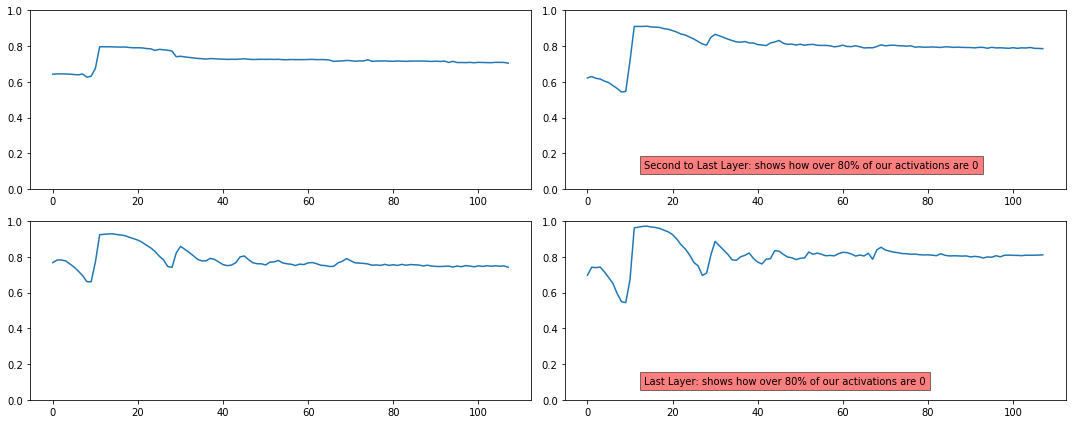

In [30]:
#function to display what activations are ~0
def get_min(h, number_bins=2):
    h1 = torch.stack(h.stats[number_bins]).t().float()
    return h1[:number_bins].sum(0)/h1.sum(0)

#plotting the results
fig,axes = plt.subplots(2,2, figsize=(15,6))
fig.text(.6,.6, "Second to Last Layer: shows how over 80% of our activations are 0",
        bbox=dict(facecolor='red', alpha=0.5))
fig.text(.6,.1, "Last Layer: shows how over 80% of our activations are 0",
        bbox=dict(facecolor='red', alpha=0.5))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [31]:
class GeneralReLU(nn.Module): #generalized ReLU class
    def __init__(self, leak=None, sub_value=None, value_cuttoff=None):
        super().__init__()
        self.leak = leak
        self.sub = sub_value
        self.cuttoff = value_cuttoff
        
    def forward(self, x_in):
        x_in = F.leaky_relu(x_in, self.leak) if self.leak is not None else F.relu(x_in)
        if self.sub is not None:
            x_in.sub_(self.sub)
        if self.cuttoff is not None:
            x_in.clamp_max_(self.cuttoff)
        return x_in
    
#passing in GeneralReLU args
def get_cnn_layers(num_categories, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], num_categories)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralReLU(**kwargs))

def init_cnn(m, uniform=False):
    f = torch.nn.init.kaiming_uniform_ if uniform else torch.nn.init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
            
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [32]:
#updated for Leaky Relu 
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

#### New Model Setup

In [33]:
model =  get_cnn_model(num_categories, number_features, conv_layer, leak=0.1, sub_value=0.4, value_cuttoff=6.)
init_cnn(model)
opt = optim.SGD(model.parameters(), lr = 0.9)
runner = Runner(cb_funcs=cbfs)

train: [0.4554644921875, tensor(0.8602, device='cuda:0')]
valid: [0.13884130859375, tensor(0.9595, device='cuda:0')]


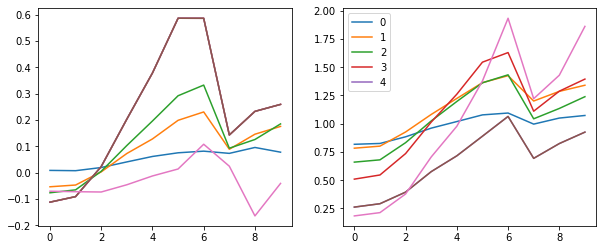

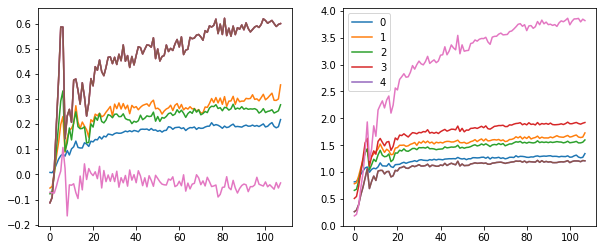

In [34]:
with Hooks(model, append_stats) as hooks:
    runner.fit(1, model, opt, loss_function, train_dl, valid_dl)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

- compared to the inital training, we're doing much better on amount of useless activations

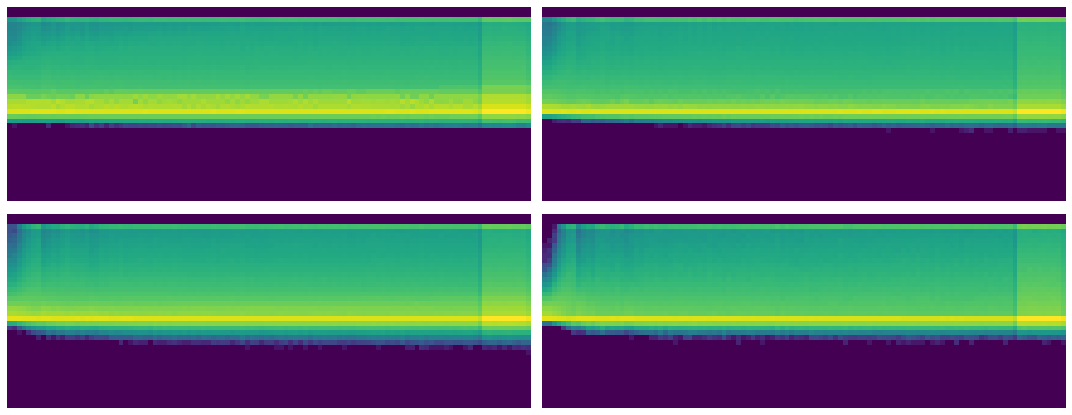

In [35]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()